In [1]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

from tqdm import tqdm


from automltsad.detectors import KNN
from automltsad.transform import MeanVarianceScaler
from automltsad.utils import sliding_window_sequences, reduce_window_scores, to_time_series, to_time_series_dataset
from automltsad.metrics import average_precision_score, roc_auc_score, f1_pa, f1_pa_auc_score, f1_pa_curve, mass_volume_curve, mass_volume_auc_score, mv_feature_subsampling_auc_score, excess_mass_curve, excess_mass_auc_score, em_feature_subsampling_auc_score, PrecisionRecallDisplay, RocCurveDisplay

warnings.filterwarnings('ignore')

# _LOGGER = logging.getLogger('automltsad')
# _LOGGER.setLevel(logging.DEBUG)
# ch = logging.StreamHandler()
# ch.setLevel(logging.DEBUG)
# formatter = logging.Formatter(
#     '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
# )
# ch.setFormatter(formatter)
# _LOGGER.addHandler(ch)


/root/.cache/pypoetry/virtualenvs/automltsad-DuHKdg10-py3.10/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
FILE_ID = 5
print(sorted(os.listdir('./data/datasets'))[FILE_ID])
file = sorted(os.listdir('./data/datasets'))[FILE_ID]

test_start, anomaly_start, anomaly_end = [
    int(i) for i in file.split('.')[0].split('_')[-3:]
]

a = np.loadtxt(f'./data/datasets/{file}')
a = to_time_series_dataset(a)

train = a[:,:test_start]
test = a[:,test_start:]

label = np.zeros_like(test)
label[:,anomaly_start-test_start:anomaly_end-test_start] = 1
label = np.squeeze(label)

006_UCR_Anomaly_DISTORTEDCIMIS44AirTemperature2_4000_5703_5727.txt


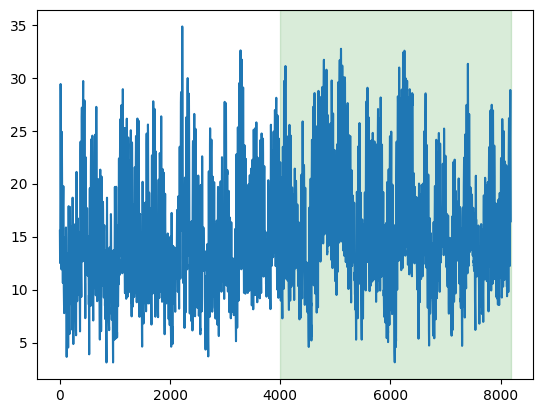

In [3]:
plt.plot(a[0])
plt.axvspan(test_start, a.shape[1], color='green', alpha=0.15)

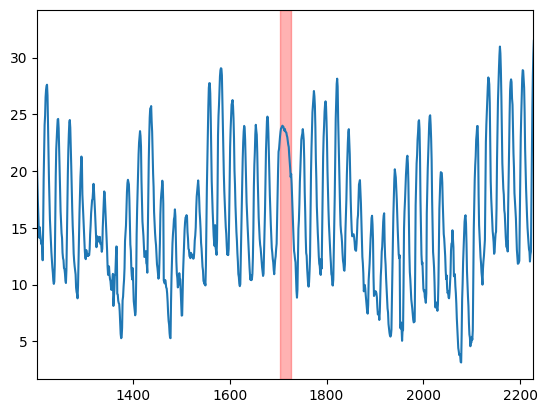

In [4]:
plt.plot(test[0])
plt.xlim(anomaly_start-test_start - 500, anomaly_end-test_start + 500)
plt.axvspan(anomaly_start-test_start, anomaly_end-test_start, color='red', alpha=0.3)
plt.show()

## MV

In [5]:
for ws in [8, 16, 32, 64, 128]:
    WINDOW_SIZE = ws

    # extract windows
    trainw = sliding_window_sequences(train, WINDOW_SIZE)
    testw = sliding_window_sequences(test, WINDOW_SIZE)
    
    # standardize windows
    slr = MeanVarianceScaler()
    trainw = slr.fit_transform(trainw)
    testw = slr.transform(testw)

    # train KNN
    det = KNN()
    det.fit(trainw)
    
    # predict anomaly scores
    anomaly_scores = det.predict_anomaly_scores(testw)
    anomaly_scores = reduce_window_scores(anomaly_scores, WINDOW_SIZE)

    # Find best threshold according to best f1-score
    p, r, t = precision_recall_curve(label, anomaly_scores)
    f1 = 2*p*r / (p+r)
    idx = np.nanargmax(f1)
    PrecisionRecallDisplay(p, r).plot()
    plt.scatter(r[idx], p[idx], marker='x', color='red', label='Best')
    plt.title(f'PR curve, Window size {ws}')
    best_t = t[idx]
    best_f1 = f1[idx]

    print(f'f1 {f1[idx]}')
    print(f'mv auc {mass_volume_auc_score(det, testw)}')
    print(f'sub mv auc {mv_feature_subsampling_auc_score(det, trainw, testw)}')

NameError: name 'precision_recall_curve' is not defined

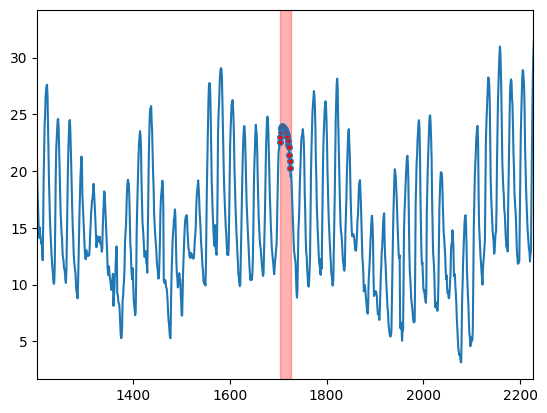

In [ ]:
plt.plot(test[0], markevery=(anomaly_scores>best_t).reshape(-1).nonzero()[0], **dict(ms=4, marker='o', markerfacecolor='red'))
plt.xlim(anomaly_start-test_start - 500, anomaly_end-test_start + 500)
plt.axvspan(anomaly_start-test_start, anomaly_end-test_start, color='red', alpha=0.3)
plt.show()

### Mass volume curve

$$
\textrm{The Mass Volume curve }MV_s\textrm{ of a scoring function }s : \mathbb{R}^d → \mathbb{R}\textrm{ is defined }\\\textrm{as the parametric curve }t \in \mathbb{R}\\(\alpha_s(t), λ_s(t))\\\textrm{ where }\alpha_s(t) = P(s(X) ≥ t)\\\textrm{ and }λs(t) = λ({x, s(x) ≥ t}).\\\textrm{ If }α_s\textrm{ has no flat parts, the Mass Volume curve }MV_s\\\textrm{ can also be defined as the function }\\MV_s : \alpha ∈ (0, 1) \rightarrow λ_s(α^{−1}_s (α)) \\\textrm{ where }α^{−1}_s (α) = inf\{t ∈ \mathbb{R}, α_s(t) ≤ α\}.
$$

$
λ\textrm{ is the Lebesgue measure on }\mathbb{R}^d
$

Mass: $\alpha_s(t) = P(s(X) ≥ t)$

Volume: $λ_s(t) = λ({x, s(x) ≥ t})$

### Algorithm pseudocode

for $\alpha \in [0.9, 0.999]$:

&emsp; $t$ = compute $1 - \alpha$ quantile of scoring function $s$.

&emsp; compute $\lambda_s(t)$ using Monte Carlo simulation.

auc($MV_s$)

### Problems

Monte Carlo doesn't work well in high dimensional spaces.

Solution: use features subsampling



## EM

In [ ]:
for n_neigh in [3,7,11,21]:
    WINDOW_SIZE = 128

    # extract windows
    trainw = sliding_window_sequences(train, WINDOW_SIZE)
    testw = sliding_window_sequences(test, WINDOW_SIZE)
    
    # standardize windows
    slr = MeanVarianceScaler()
    trainw = slr.fit_transform(trainw)
    testw = slr.transform(testw)

    # train KNN
    det = KNN(n_neighbors=n_neigh)
    det.fit(trainw)
    
    # predict anomaly scores
    anomaly_scores = det.predict_anomaly_scores(testw)
    anomaly_scores = reduce_window_scores(anomaly_scores, WINDOW_SIZE)

    # Find best threshold according to best f1-score
    p, r, t = precision_recall_curve(label, anomaly_scores)
    f1 = 2*p*r / (p+r)
    idx = np.nanargmax(f1)
    # PrecisionRecallDisplay(p, r).plot()
    # plt.scatter(r[idx], p[idx], marker='x', color='red', label='Best')
    # plt.title(f'PR curve, Window size {ws}')
    best_t = t[idx]
    best_f1 = f1[idx]

    print(f'f1 {f1[idx]}')
    print(f'em auc {em_feature_subsampling_auc_score(det,trainw, testw)}')

    

f1 1.0
em auc 0.0001891493790717729
f1 1.0
em auc 0.0001975656077452681
f1 1.0
em auc 0.0002108619756943212
f1 0.9795918367346939
em auc 0.000184286034876792


In [ ]:
plt.plot(test[0], markevery=(anomaly_scores>best_t).reshape(-1).nonzero()[0], **dict(ms=4, marker='o', markerfacecolor='red'))
plt.xlim(anomaly_start-test_start - 500, anomaly_end-test_start + 500)
plt.axvspan(anomaly_start-test_start, anomaly_end-test_start, color='red', alpha=0.3)
plt.show()